# Integer Branch-and-Cut for the TSP (Animated)

Note: the animated version works when ran on a Jupyter Notebook in the browser, but it does *not* work if you open the notebook in Visual Studio Code.

In [1]:
%matplotlib notebook

from typing import Dict, Tuple, List
from math import sqrt
from dataclasses import dataclass
from gurobipy import Model, GRB, tupledict, LinExpr
import time

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

In [2]:
class TspInstance:
    """ An instance of the Travelling Salesman Problem.

        Attributes
        ----------
        n_vertices: int
            Number of vertices in the graph.
        x: List[float]
            X coordinates of the vertices (for plotting).
        y: List[float]
            Y coordinates of the vertices (for plotting).
        cost: Dict[Tuple[int, int], float]
            Dictionary with arcs as key, and their corresponding
            costs as values.
    """

    n_vertices: int
    x: List[float]
    y: List[float]
    cost: Dict[Tuple[int, int], float]

    def __euclidean_distance(self, i: int, j: int) -> float:
        assert 0 <= i < self.n_vertices
        assert 0 <= j < self.n_vertices
        return sqrt((self.x[i] - self.x[j]) ** 2 + (self.y[i] - self.y[j]) ** 2)

    def __init__(self, file: str):
        """ Reads a (Euclidean) TSP instance from file.

            The file must follow the following format. The first
            line must contain a single integer number, representing
            the number of vertices (n) in the graph. The next n
            lines must contain two floating point numbers separated
            by a space. These are the x and y coordinates of each
            vertex. The cost to travel from i to j will be computed
            as the euclidean distance between them.

            Parameters
            ----------
            file: str
                Path to the file containing the instance.
        """

        with open(file) as f:
            # First line
            self.n_vertices = int(f.readline().strip())

            # Subsequent n_vertices lines
            self.x, self.y = zip(*[map(float, f.readline().strip().split()) for _ in range(self.n_vertices)])

            # Create the cost dictionary from the x-y coordinates
            self.cost = {
                (i, j): self.__euclidean_distance(i, j)
                for i in range(self.n_vertices)
                for j in range(self.n_vertices)
                if i != j
            }

In [3]:
@dataclass
class TspSolution:
    """ Solution to an instance of the Travelling Salesman Problem.

        Attributes
        ----------
        instance: TspInstance
            Reference to the TSP instance being solved.
        tour: List[int]
            Ordered list of vertices visited (without repeating the first one).
        cost: float
            Travel cost of the tour.
    """

    instance: TspInstance
    tour: List[int]
    cost: float

In [4]:
class AnimatedTspIntegerBCSolver:
    """ Solver for the Travelling Salesman Problem.
    
        It uses the branch-and-cut algorithm applied to the "DFJ" formulation.
        Subtour elimination constraints are separated on integer solutions only.
    """

    _instance: TspInstance
    _V: List[int]
    _A: List[Tuple[int, int]]
    _model: Model
    _x: tupledict
    _fig: Figure
    _ax: plt.Axes

    def __init__(self, instance: TspInstance):
        """ Initialises the solver and builds the model.
        
            Parameters
            ----------
            instance: TspInstance
                The TSP instance.
        """

        self._instance = instance
        self._V = list(range(self._instance.n_vertices))
        self._A = list(self._instance.cost.keys())
        self.__build_model()

    def __build_model(self) -> None:
        """ Builds the DFJ model without SECs. """
         
        self._model = Model()
        self._x = self._model.addVars(self._A, obj=self._instance.cost, vtype=GRB.BINARY, name='x')
        self._model.addConstrs((self._x.sum(i, '*') == 1 for i in self._V), name='outgoing')
        self._model.addConstrs((self._x.sum('*', i) == 1 for i in self._V), name='incoming')

    def __next_vertex(self, i: int) -> int:
        """ Gets the vertex visited immediately after i in the current TSP solution.

            This is the (only) vertex j such that x[i,j] == 1. This function works both
            when inside a callback (when the value of x must be retrieved via cbGetSolution)
            and after the optimisation is over (when the value of X can be accessed via X).
        """

        assert 0 <= i < self._instance.n_vertices

        for j in self._V:
            if i != j:
                try:
                    # If inside a call-back, we use cbGetSolution
                    val = self._model.cbGetSolution(self._x[i, j])
                except:
                    # Otherwise we use .X
                    val = self._x[i, j].X

                if val > 0.5:
                    return j

        assert False, f"Vertex {j} has no successor?!"

    def __tour_staring_at(self, i: int) -> List[int]:
        """ Gives the (sub)tour starting at a given vertex i in the current TSP solution. """

        assert 0 <= i < self._instance.n_vertices

        tour = [i]
        current = self.__next_vertex(i)

        while current != i:
            tour.append(current)
            current = self.__next_vertex(current)

        return tour

    def __add_sec_for(self, S: List[int]) -> None:
        """ Adds a Subtour Elimination Constraint for set S. """

        assert 0 < len(S) < self._instance.n_vertices

        self._model.cbLazy(sum(self._x[i, j] for (i, j) in self._A if i in S and j not in S) >= 1)

    def __separate(self, where: int) -> None:
        """ Separates eventual violated SECs. """

        if where != GRB.Callback.MIPSOL:
            return

        self._ax.clear()
        self.__plot_instance()
        
        # Set of vertices not yet placed in a tour
        remaining = set(self._V)

        # Set of all subtours in the solution
        subtours = list()

        while len(remaining) > 0:
            # Get any vertex in set `remaining`
            current = next(iter(remaining))

            # Get the subtour which includes the vertex
            subtour = self.__tour_staring_at(current)

            # Store subtour
            subtours.append(subtour)

            # If the tour visits all vertices, nothing to do
            if len(subtour) == self._instance.n_vertices:
                break

            # Otherwise, it's a subtour => Add a SEC
            self.__add_sec_for(subtour)

            # Update set `remaining`
            remaining -= set(subtour)

        cost = self._model.cbGet(GRB.Callback.MIPSOL_OBJ)
            
        if len(subtours) == 1:
            self._ax.set_title(f"Feasible solution cost: {cost:.2f}")
        else:
            self._ax.set_title(f"Infeasible colution cost: {cost:.2f}")
            
        for subtour in subtours:
            # Plot the subtours
            self.__plot_tour(subtour)

        time.sleep(1)
            
    def __plot_instance(self) -> None:
        """ Plots the cities of the instance as black dots. """
        
        self._ax.scatter(self._instance.x, self._instance.y, color='black')
        
    def __plot_tour(self, tour: List[int]) -> None:
        """ Plots a tour with blue lines (if it is a proper tour)
            or with red lines (if it is a subtour).
        """
        
        feasible = (len(tour) == self._instance.n_vertices)
        col = 'blue' if feasible else 'red'
        xy = [(self._instance.x[i], self._instance.y[i]) for i in tour + [tour[0]]]
        
        for pt1, pt2 in zip(xy[1:], xy[:-1]):
            x1, y1 = pt1
            x2, y2 = pt2
            self._ax.plot([x1, x2], [y1, y2], color=col)
            
        self._fig.canvas.draw()

    def solve(self) -> TspSolution:
        """ Solves the TSP DFJ model and returns the solution.
        
            It throws a RuntimeError if Gurobi cannot solve the model to optimality.
            It shows all feasible and unfeasible integer solution which Gurobi finds
            during the exploration of the branch-and-bound tree.

            Returns
            -------
            A TspSolution object with details about the solution.
        """

        # We must set this parameter to use callbacks
        self._model.setParam(GRB.Param.LazyConstraints, 1)

        # Initialise the figure
        self._fig, self._ax = plt.subplots(figsize=(10,10))
        self._fig.show()
        self.__plot_instance()

        # Gurobi always passes two parameters to the callback: `model` and `where`
        self._model.optimize(lambda _, where: self.__separate(where))

        if self._model.Status != GRB.OPTIMAL:
            raise RuntimeError(f"Could not find the optimal solution. Gurobi status = {self._model.Status}")

        return TspSolution(
            instance=self._instance,
            tour=self.__tour_staring_at(0),
            cost=self._model.ObjVal
        )


In [5]:
i = TspInstance(file='../data/tsp-instance.txt')

In [6]:
s = AnimatedTspIntegerBCSolver(instance=i)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-28


Set parameter LazyConstraints to value 1


<IPython.core.display.Javascript object>


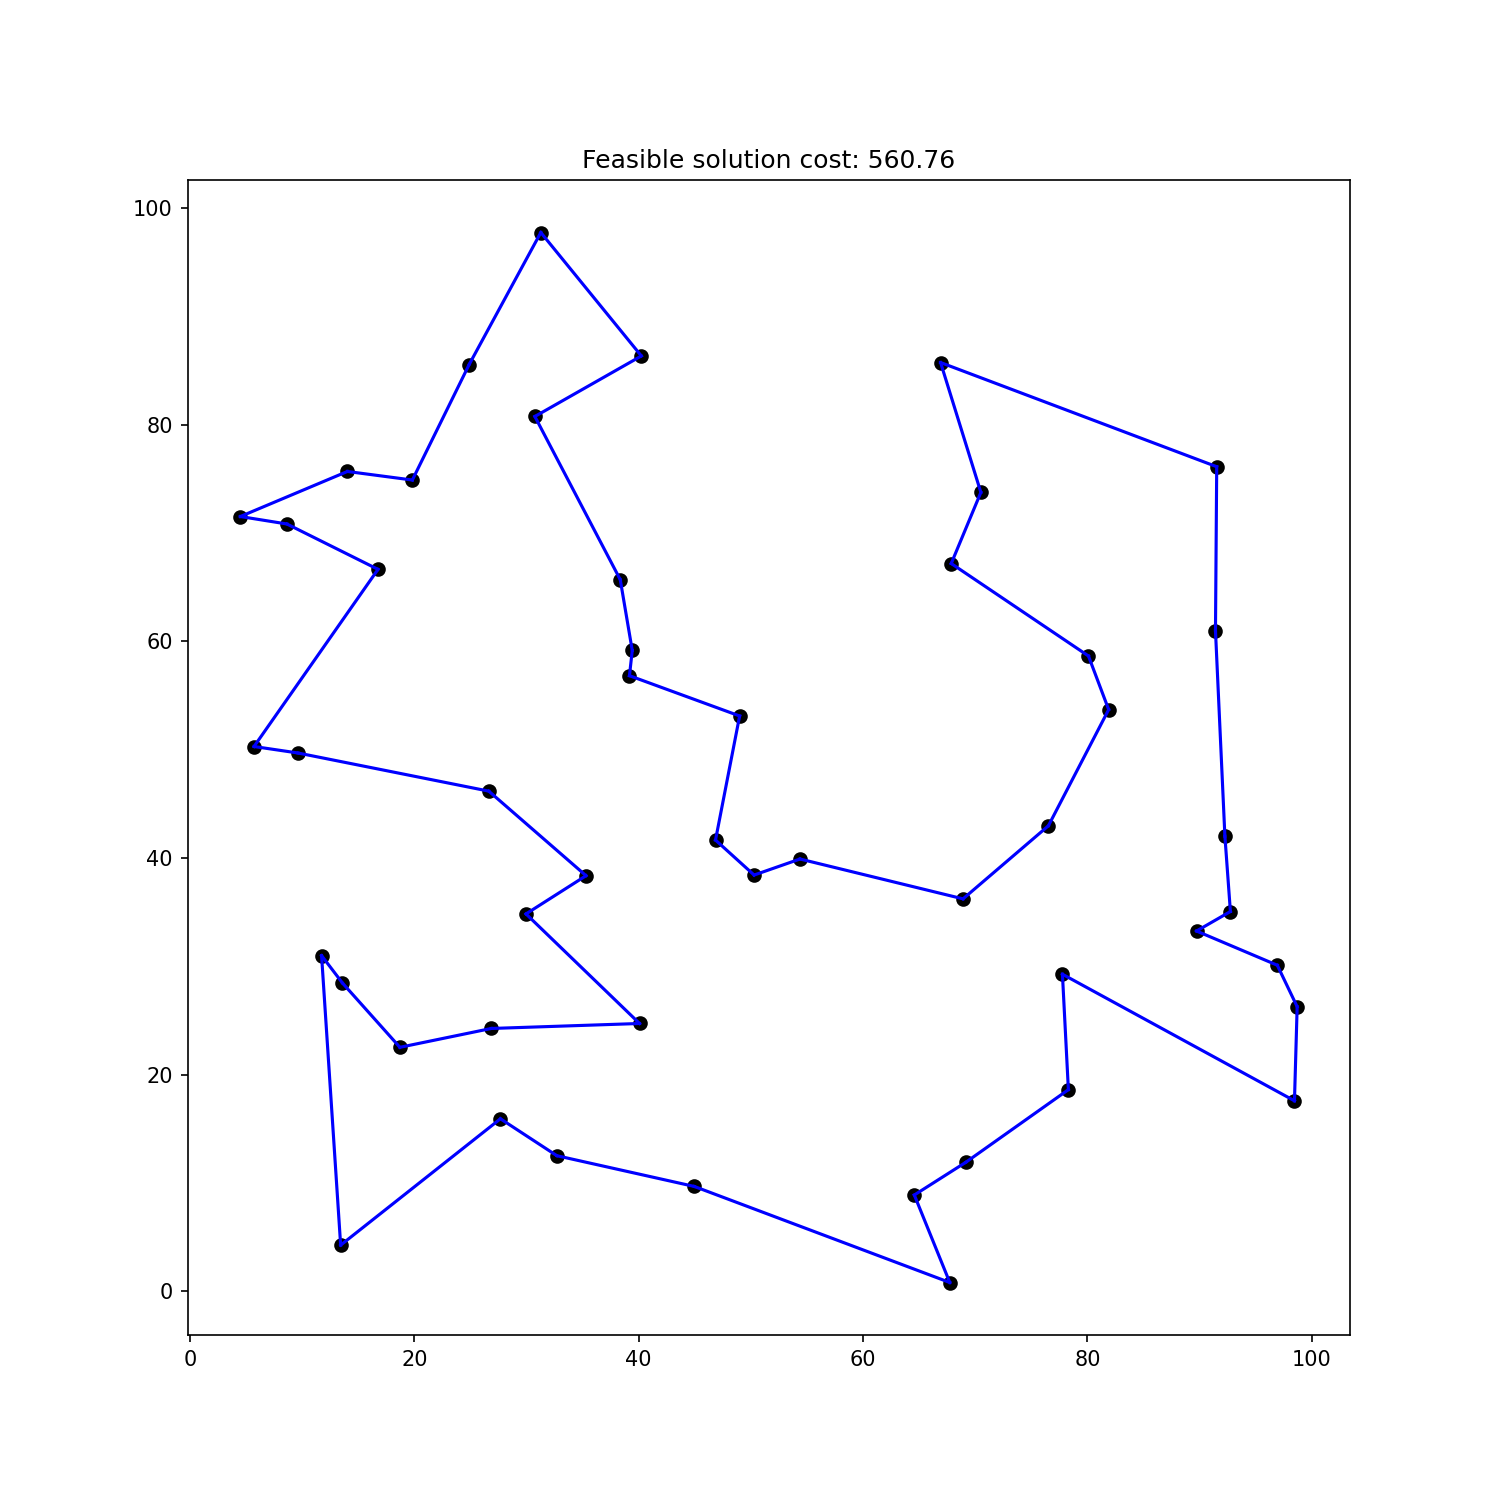

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 100 rows, 2450 columns and 4900 nonzeros
Model fingerprint: 0xb06afe35
Variable types: 0 continuous, 2450 integer (2450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2543.7515673
Presolve time: 0.01s
Presolved: 100 rows, 2450 columns, 4900 nonzeros
Variable types: 0 continuous, 2450 integer (2450 binary)

Root relaxation: objective 4.552846e+02, 81 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  558.24218    0   20 2543.75157  558.24218  78.1%     -    7s
H    0     0                    2050.7501711  558.24218  72.8%    

In [7]:
solution = s.solve()